# Supervised Classification Benchmark

This notebook benchmarks three complementary supervised classification algorithms on the cybersecurity dataset. Each algorithm represents a different learning paradigm:

1.  **Logistic Regression**: Linear model (Base line).
2.  **Random Forest**: Bagging Ensemble (Reduces variance).
3.  **Histogram Gradient Boosting**: Boosting Ensemble (Reduces bias, high performance).

**Metrics:**
*   Confusion Matrix
*   Precision, Recall
*   AUPRC (Average Precision)
*   Balanced Accuracy
*   Matthews Correlation Coefficient (MCC)

## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, 
                             average_precision_score, balanced_accuracy_score, 
                             matthews_corrcoef, precision_recall_curve)

# Load data
pkl_path = '../data/packet_data_balanced.pkl'
print(f"Loading data from {pkl_path}...")
try:
    df = pd.read_pickle(pkl_path)
    print(f"Data loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: {pkl_path} not found.")

# Quick check of the target
print(df['Main_Label'].value_counts())

Loading data from ../data/packet_data_balanced.pkl...
Data loaded successfully. Shape: (500000, 138)
Main_Label
Web-Based        62500
Mirai            62500
Recon            62500
Spoofing         62500
DDoS             62500
BenignTraffic    62500
BruteForce       62500
DoS              62500
Name: count, dtype: int64
Data loaded successfully. Shape: (500000, 138)
Main_Label
Web-Based        62500
Mirai            62500
Recon            62500
Spoofing         62500
DDoS             62500
BenignTraffic    62500
BruteForce       62500
DoS              62500
Name: count, dtype: int64


In [2]:
# 2. Data Preprocessing
print("Preprocessing...")

# 1. Target: Multiclass Labels 'Main_Label'
y = df['Main_Label'].values

# 2. Drop Identifiers
cols_to_drop = ['Main_Label', 'Sub_Label', 'Source_File', 'src_ip', 'dst_ip', 'src_mac', 'dst_mac', 'Timestamp', 'Flow ID', 'Label']
existing_cols_to_drop = [c for c in cols_to_drop if c in df.columns]
X_raw = df.drop(columns=existing_cols_to_drop)

# Select numeric
X_numeric = X_raw.select_dtypes(include=[np.number])
print(f"Features shape: {X_numeric.shape}")

# 3. Handle Missing
X_clean = X_numeric.fillna(X_numeric.mean()).fillna(0)

# 4. Train/Test Split (Stratified)
print("Splitting data (80% Train, 20% Test)...")
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_clean, y, test_size=0.2, stratify=y, random_state=42
)

# 5. Scaling (Fit on Train, Transform on Test)
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train_scaled.shape}, Test set: {X_test_scaled.shape}")
print("Classes:", np.unique(y))

Preprocessing...
Features shape: (500000, 119)
Splitting data (80% Train, 20% Test)...
Splitting data (80% Train, 20% Test)...
Scaling features...
Scaling features...
Train set: (400000, 119), Test set: (100000, 119)
Classes: ['BenignTraffic' 'BruteForce' 'DDoS' 'DoS' 'Mirai' 'Recon' 'Spoofing'
 'Web-Based']
Train set: (400000, 119), Test set: (100000, 119)
Classes: ['BenignTraffic' 'BruteForce' 'DDoS' 'DoS' 'Mirai' 'Recon' 'Spoofing'
 'Web-Based']


In [3]:
# Helper Function for Evaluation
from sklearn.metrics import classification_report, accuracy_score

def evaluate_supervised_multiclass(y_true, y_pred, model_name):
    print(f"\n--- {model_name} ---")
    
    # Simple Accuracy
    acc = accuracy_score(y_true, y_pred)
    # Balanced Accuracy (macro average of recall per class)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    # MCC (supports multiclass natively in scikit-learn)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"MCC: {mcc:.4f}")
    
    # Detailed Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    # Using sorted unique labels to ensure consistency
    labels = sorted(list(set(y_true) | set(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    return {
        "Model": model_name,
        "Accuracy": acc,
        "Balanced Accuracy": bal_acc,
        "MCC": mcc
    }

results = []

### Model 1: Logistic Regression

**How it works:**
Logistic Regression is a linear classification algorithm that models the probability of a binary outcome. It applies the sigmoid function to a weighted sum of input features to output a probability between 0 and 1. If the probability is greater than 0.5 (or another threshold), the sample is classified as the positive class.

**Why it is appropriate:**
*   **Baseline:** It serves as an excellent "baseline" model. If Logistic Regression performs well, it suggests the data is linearly separable, and more complex models might not be needed.
*   **Interpretability:** The weights assigned to each feature directly indicate their importance and direction of influence (positive or negative correlation with the anomaly).
*   **Efficiency:** It is computationally very fast to train and predict, making it suitable for high-speed network traffic analysis.
*   **Constraint:** It assumes a linear relationship between features and the log-odds of the class, which might be too simple for complex attack patterns.

Training Logistic Regression (Multiclass)...


/home/baptiste/Documents/ING3/mlsecu/CyberML/.env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


Training Logistic Regression (Multiclass)...


/home/baptiste/Documents/ING3/mlsecu/CyberML/.env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)



--- Logistic Regression ---
Accuracy: 0.8337
Balanced Accuracy: 0.8337
MCC: 0.8115

Classification Report:
Accuracy: 0.8337
Balanced Accuracy: 0.8337
MCC: 0.8115

Classification Report:
               precision    recall  f1-score   support

BenignTraffic       0.63      0.70      0.66     12500
   BruteForce       0.99      0.93      0.96     12500
         DDoS       0.96      0.85      0.90     12500
          DoS       0.91      0.93      0.92     12500
        Mirai       0.99      0.97      0.98     12500
        Recon       0.83      0.75      0.79     12500
     Spoofing       0.92      0.73      0.81     12500
    Web-Based       0.60      0.81      0.69     12500

     accuracy                           0.83    100000
    macro avg       0.85      0.83      0.84    100000
 weighted avg       0.85      0.83      0.84    100000

               precision    recall  f1-score   support

BenignTraffic       0.63      0.70      0.66     12500
   BruteForce       0.99      0.93     

Training Logistic Regression (Multiclass)...


/home/baptiste/Documents/ING3/mlsecu/CyberML/.env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)



--- Logistic Regression ---
Accuracy: 0.8337
Balanced Accuracy: 0.8337
MCC: 0.8115

Classification Report:
Accuracy: 0.8337
Balanced Accuracy: 0.8337
MCC: 0.8115

Classification Report:
               precision    recall  f1-score   support

BenignTraffic       0.63      0.70      0.66     12500
   BruteForce       0.99      0.93      0.96     12500
         DDoS       0.96      0.85      0.90     12500
          DoS       0.91      0.93      0.92     12500
        Mirai       0.99      0.97      0.98     12500
        Recon       0.83      0.75      0.79     12500
     Spoofing       0.92      0.73      0.81     12500
    Web-Based       0.60      0.81      0.69     12500

     accuracy                           0.83    100000
    macro avg       0.85      0.83      0.84    100000
 weighted avg       0.85      0.83      0.84    100000

               precision    recall  f1-score   support

BenignTraffic       0.63      0.70      0.66     12500
   BruteForce       0.99      0.93     

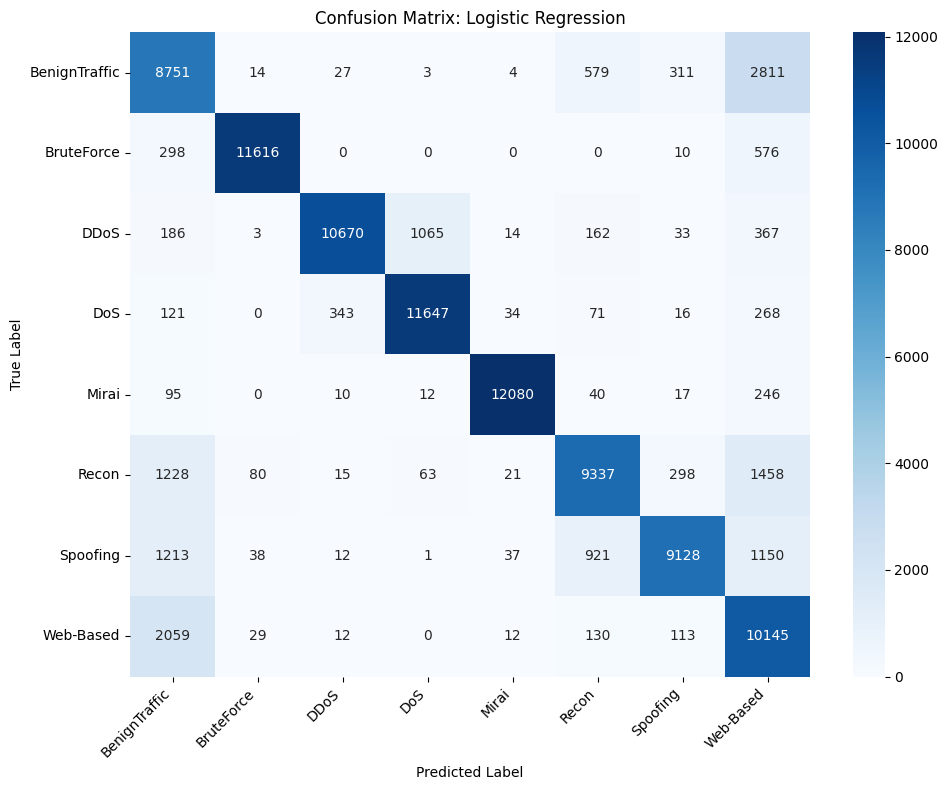

In [7]:
# Model 1: Logistic Regression (Multinomial)
print("Training Logistic Regression (Multiclass)...")

# 'lbfgs' is the default solver in newer sklearn versions and handles multiclass automatically.
# The 'multi_class' parameter caused an error, so we rely on automatic detection (default='auto').
lr = LogisticRegression(class_weight='balanced', 
                        random_state=42, 
                        max_iter=2000,
                        n_jobs=-1, 
                        solver='lbfgs')  

lr.fit(X_train_scaled, y_train_val)

y_pred_lr = lr.predict(X_test_scaled)
# (Optional) y_prob_lr = lr.predict_proba(X_test_scaled)

res_lr = evaluate_supervised_multiclass(y_test, y_pred_lr, "Logistic Regression")
results.append(res_lr)

### Model 2: Random Forest

**How it works:**
Random Forest is a **Bagging (Bootstrap Aggregating)** ensemble method. It builds multiple independent decision trees during training. Each tree is trained on a random subset of the data (bootstrap sample) and considers only a random subset of features at each split. The final prediction is the majority vote (or average probability) of all the trees.

**Why it is appropriate:**
*   **Variance Reduction:** By averaging many trees, it effectively reduces overfitting compared to a single decision tree. This makes it robust to noise in network data.
*   **Non-Linearity:** It can capture complex, non-linear relationships and interactions between network features without needing feature transformation.
*   **Robustness:** It handles outliers well and isn't heavily impacted by the scale of features (though we scaled them anyway).
*   **Feature Importance:** It provides a reliable measure of feature importance, helping us understand which network headers are most critical for checking attacks.

Training Random Forest...

--- Random Forest ---
Accuracy: 0.9852
Balanced Accuracy: 0.9852
MCC: 0.9831

Classification Report:
               precision    recall  f1-score   support

BenignTraffic       0.97      0.99      0.98     12500
   BruteForce       1.00      1.00      1.00     12500
         DDoS       1.00      0.97      0.98     12500
          DoS       1.00      0.99      0.99     12500
        Mirai       1.00      0.99      0.99     12500
        Recon       0.98      0.97      0.98     12500
     Spoofing       0.99      0.97      0.98     12500
    Web-Based       0.95      1.00      0.97     12500

     accuracy                           0.99    100000
    macro avg       0.99      0.99      0.99    100000
 weighted avg       0.99      0.99      0.99    100000



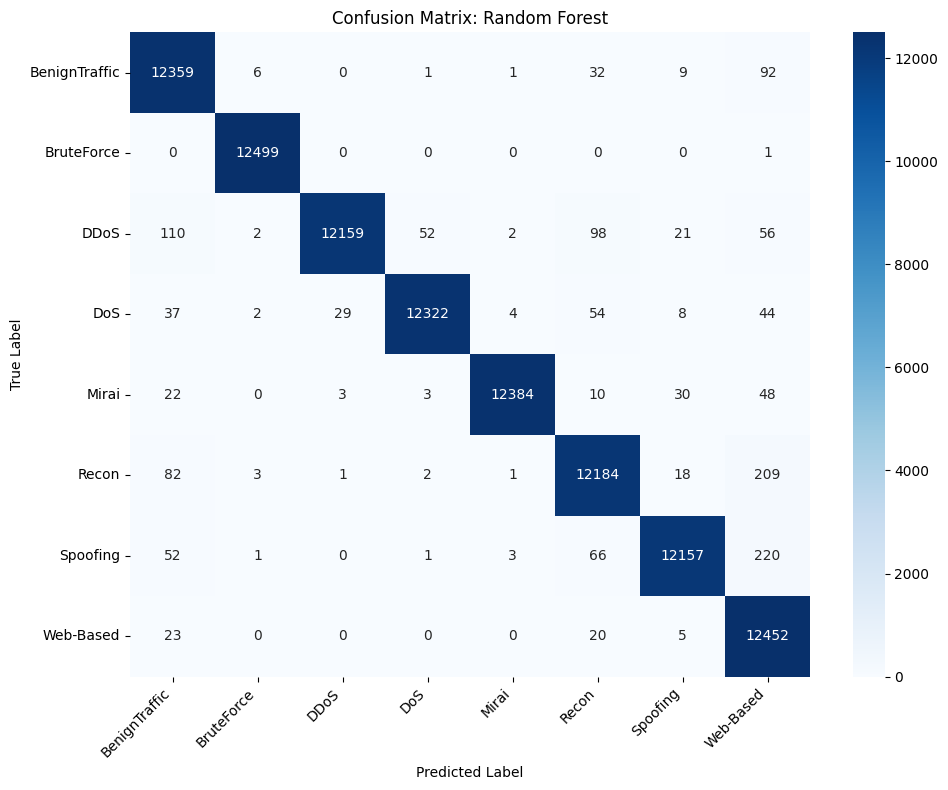

In [8]:
# Model 2: Random Forest
print("Training Random Forest...")
# RandomForestClassifier natively supports multiclass classification.
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train_val)

y_pred_rf = rf.predict(X_test_scaled)
# (Optional) y_prob_rf = rf.predict_proba(X_test_scaled)

res_rf = evaluate_supervised_multiclass(y_test, y_pred_rf, "Random Forest")
results.append(res_rf)

### Model 3: Histogram Gradient Boosting

**How it works:**
Gradient Boosting is a **Boosting** ensemble method. Unlike Random Forest (which builds trees in parallel), Boosting builds trees sequentially. Each new tree focuses on correcting the errors (residuals) made by the previous ensemble. `HistGradientBoostingClassifier` is an optimized implementation (inspired by LightGBM) that bins continuous input variables into histograms, significantly speeding up training on large datasets.

**Why it is appropriate:**
*   **Bias Reduction:** By sequentially fixing errors, it can achieve extremely high accuracy and low bias, often outperforming Random Forest on tabular data.
*   **Speed & Scalability:** The histogram-based approach is much faster than traditional Gradient Boosting for large datasets (like our millions of packets).
*   **Handling Imbalance:** It has built-in mechanisms to handle class imbalance effectively.
*   **Precision:** It often produces very well-calibrated probabilities, which is crucial if we want to set a precise confidence threshold for blocking network traffic.

Training Histogram Gradient Boosting...

--- Hist Gradient Boosting ---
Accuracy: 0.9879
Balanced Accuracy: 0.9879
MCC: 0.9862

Classification Report:
               precision    recall  f1-score   support

BenignTraffic       0.98      0.99      0.98     12500
   BruteForce       1.00      1.00      1.00     12500
         DDoS       0.99      0.98      0.99     12500
          DoS       0.99      0.99      0.99     12500
        Mirai       1.00      0.99      1.00     12500
        Recon       0.99      0.97      0.98     12500
     Spoofing       0.99      0.98      0.99     12500
    Web-Based       0.95      1.00      0.97     12500

     accuracy                           0.99    100000
    macro avg       0.99      0.99      0.99    100000
 weighted avg       0.99      0.99      0.99    100000



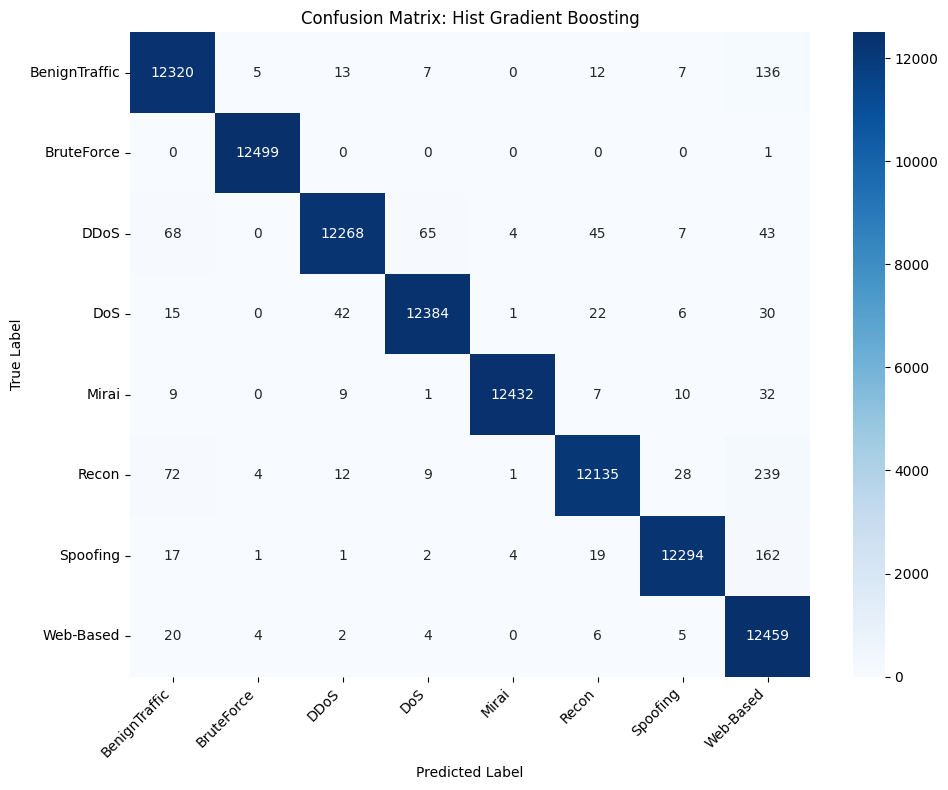

In [9]:
# Model 3: Histogram Gradient Boosting 
print("Training Histogram Gradient Boosting...")
# HistGradientBoostingClassifier natively supports multiclass classification.
try:
    gb = HistGradientBoostingClassifier(class_weight='balanced', random_state=42)
    gb.fit(X_train_scaled, y_train_val)
except TypeError:
    print("Warning: class_weight not supported in this sklearn version for HistGradientBoosting. Training without.")
    gb = HistGradientBoostingClassifier(random_state=42)
    gb.fit(X_train_scaled, y_train_val)

y_pred_gb = gb.predict(X_test_scaled)
# (Optional) y_prob_gb = gb.predict_proba(X_test_scaled)

res_gb = evaluate_supervised_multiclass(y_test, y_pred_gb, "Hist Gradient Boosting")
results.append(res_gb)

In [10]:
# Visualization of Benchmark
results_df = pd.DataFrame(results)

print("\n--- Final Benchmark Results ---")
display(results_df)

# Plotting
metrics_to_plot = ['Precision', 'Recall', 'Balanced Accuracy', 'MCC', 'AUPRC']

# Melt for seaborn
results_melted = results_df.melt(id_vars="Model", value_vars=metrics_to_plot, var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric', palette='viridis')
plt.title("Supervised Classification Benchmark")
plt.ylim(0, 1.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


--- Final Benchmark Results ---


,Model,Accuracy,Balanced Accuracy,MCC
0,Logistic Regression,0.83374,0.83374,0.811541
1,Random Forest,0.98516,0.98516,0.983074
2,Hist Gradient Boosting,0.98791,0.98791,0.986210


KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['Precision', 'Recall', 'AUPRC']"